In [209]:
# Importing all necessary package
import os
import numpy as np
from PIL import Image


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#A generalist algorithm for cell and nucleus segmentation (v1.0) that can be optimized for your own data (v2.0)
from cellpose.models import Cellpose 
from stardist.models import StarDist2D

from csbdeep.utils import normalize

import tensorflow as tf

from tensorflow import keras
from tensorflow.config import list_physical_devices

# Setting the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check if GPU is available
if len(list_physical_devices("GPU")) >= 1:
    use_GPU = True
    tf.config.experimental.set_memory_growth(list_physical_devices("GPU")[0], True)

else:
    use_GPU = False

def load_cellpose():
    """Load the cellpose model and return it"""
    model_c = Cellpose(gpu=use_GPU, model_type="cyto2")
    return model_c


def load_stardist():
    """Load the Stardist model and return it"""
    model_s = StarDist2D.from_pretrained("2D_versatile_he")
    return model_s


def run_cellpose(image, model_cellpose, diameter=None):
    """Run the cellpose model on the image and return the mask"""
    channel = [[0, 0]]
    mask_cellpose, _, _, _ = model_cellpose.eval(
        image, batch_size=1, diameter=diameter, channels=channel
    )
    return mask_cellpose


def run_stardist(image, model_stardist, nms_thresh=0.4, prob_thresh=0.5):
    """Run the stardist model on the image and return the mask"""
    img_norm = image / 255
    img_norm = normalize(img_norm, 1, 99.8)
    mask_stardist, _ = model_stardist.predict_instances(
        img_norm, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return mask_stardist

model_cellpose = load_cellpose()
model_stardist = load_stardist()

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [ ]:
pip install seaborn

In [210]:
import seaborn as sns

In [211]:
# Load an image, run CellPose to detect muscle fibers and Stardist to detect nuclei.
try:
    from imageio.v2 import imread
except:
    from imageio import imread

img = imread("sample_img/sample_he.jpg")

# CellPose
mask_cellpose = run_cellpose(
    img, model_cellpose)
mask_cellpose = mask_cellpose.astype(np.uint16)
cellpose_mask_filename = "results/sample_he_cellpose_mask.tiff"
Image.fromarray(mask_cellpose).save(cellpose_mask_filename)

# Stardist
mask_stardist = run_stardist(
    img, model_stardist)
mask_stardist = mask_stardist.astype(np.uint16)
stardist_filename = "results/sample_he_stardist_mask.tiff"
Image.fromarray(mask_stardist).save(stardist_filename)

1/1 [==============================] - 1s 973ms/step


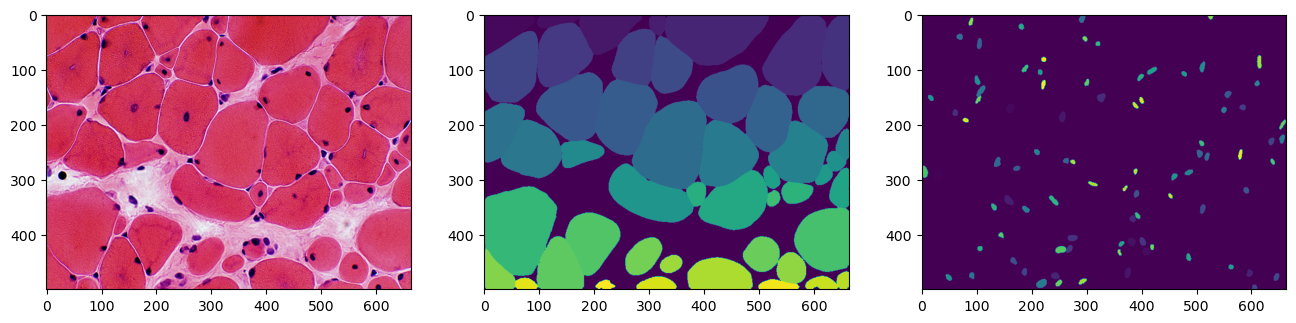

In [212]:
# Show  the raw image, the muscle fiber detected and the nuclei detected.
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
ax1.imshow(img)
ax2.imshow(mask_cellpose)
ax3.imshow(mask_stardist)
plt.show()

In [ ]:
mask_cellpose.shape

In [213]:
# Based on the Cellpose Image and Stardist image we will extract the coordinates of the nuclei and muscle fibers as a table. 
# We will also extract their area in pixels, perimeter, eccentrictiy....
from skimage.measure import regionprops_table
import pandas as pd
props_cellpose = regionprops_table(
    mask_cellpose,
    properties=[
        "label",
        "area",
        "centroid",
        "eccentricity",
        "bbox",
        "image",
        "perimeter",
        "feret_diameter_max"#ajout du diamètre
    ],
)
df_cellpose = pd.DataFrame(props_cellpose)
df_cellpose

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter,feret_diameter_max
0,1,4472,27.291816,35.942084,0.811990,0,0,74,92,"[[False, False, False, False, True, True, True...",288.166522,112.414412
1,2,1432,10.187151,130.493715,0.959465,0,96,26,175,"[[False, False, False, False, False, False, Fa...",184.568542,80.230917
2,3,5612,28.721668,222.465966,0.734992,0,173,74,288,"[[False, False, False, False, False, False, Fa...",324.592929,116.400172
3,4,964,17.978216,315.574689,0.593579,0,300,40,332,"[[False, False, False, False, False, False, Fa...",118.325902,41.000000
4,5,12970,37.791904,417.217579,0.850622,0,329,94,518,"[[False, False, False, False, False, False, Fa...",484.676190,191.211924
5,6,11918,77.677882,570.009398,0.779154,0,506,149,623,"[[False, False, False, False, False, False, Fa...",437.102597,156.869372
6,7,5628,70.467839,641.894279,0.930286,0,615,140,664,"[[False, False, False, False, False, False, Fa...",336.166522,140.174891
7,8,8819,73.265109,141.965416,0.609670,15,96,134,199,"[[False, False, False, False, False, False, Fa...",368.019336,128.035151
8,9,6269,79.019461,275.208646,0.715238,27,232,130,312,"[[False, False, False, False, False, False, Fa...",314.208153,109.553640
9,10,9847,99.798314,50.879151,0.730104,31,0,161,99,"[[False, False, False, False, False, False, Fa...",391.320851,146.123236


In [ ]:
x=50/80
x

In [ ]:
def conversion_pix_µm(data_frame,barre_echelle):
    'Convetion du diamètre en µm'
    data_frame['diameter_µm']=(data_frame['feret_diameter_max'])*barre_echelle


In [ ]:
conversion_pix_µm(df_cellpose,0.625)
df_cellpose

In [ ]:
#df_cellpose['diameter_µm']=(df_cellpose['feret_diameter_max'])*0.625
#df_cellpose
#-> je l'ai fait en une fonction 

In [ ]:
#df_cellpose['area_µm^2']=(df_cellpose['area'])*(0.39)
#df_cellpose

In [ ]:
df_cellpose.describe()

In [ ]:
sns.displot(data=df_cellpose,x= 'diameter_µm' ,kde= True)

In [ ]:
df1=df_cellpose.sort_values(by='diameter_µm')
df1

In [ ]:
#j'ai ajouté le paramètre im
#def count_atrophic_cells (min_size, max_size):
    #hyper='Hypertrophy'
    #hypo= 'Hypotrophy'
    #norm= 'Normal'
    #df1["State_cell"] = ''
    #for index in df1.index:
       # a=df1['diameter_µm'][index]
        #if a > max_size:
            #df1["State_cell"][index]=hyper
       # elif a < min_size:
            #df1["State_cell"][index]=hypo
        #else: 
            #df1["State_cell"][index]= norm
   

In [ ]:
def count_atrophic_cells (data_frame,min_size, max_size):
    hyper='Hypertrophy'
    hypo= 'Hypotrophy'
    norm= 'Normal'
    data_frame["State_cell"] = ''
    for index in df1.index:
        a=data_frame['diameter_µm'][index]
        if a > max_size:
            data_frame["State_cell"][index]=hyper
        elif a < min_size:
            data_frame["State_cell"][index]=hypo
        else: 
            data_frame["State_cell"][index]= norm


count_atrophic_cells (df1, 30, 80)

In [ ]:
df1

In [214]:
def conversion_pix_µm(data_frame,barre_echelle):
    'Convetion du diamètre en µm'
    data_frame['diameter_µm']=(data_frame['feret_diameter_max'])*barre_echelle

conversion_pix_µm(df_cellpose,0.625)

def count_atrophic_cells (data_frame,min_size, max_size):
    hyper='Hypertrophy'
    hypo= 'Hypotrophy'
    norm= 'Normal'
    data_frame["State_cell"] = ''
    for index in df1.index:
        a=data_frame['diameter_µm'][index]
        if a > max_size:
            data_frame["State_cell"][index]=hyper
        elif a < min_size:
            data_frame["State_cell"][index]=hypo
        else: 
            data_frame["State_cell"][index]= norm


count_atrophic_cells (df_cellpose, 30, 80)

df_cellpose


3925492139.py (17): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
3925492139.py (19): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
3925492139.py (15): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter,feret_diameter_max,diameter_µm,State_cell
0,1,4472,27.291816,35.942084,0.811990,0,0,74,92,"[[False, False, False, False, True, True, True...",288.166522,112.414412,70.259007,Normal
1,2,1432,10.187151,130.493715,0.959465,0,96,26,175,"[[False, False, False, False, False, False, Fa...",184.568542,80.230917,50.144323,Normal
2,3,5612,28.721668,222.465966,0.734992,0,173,74,288,"[[False, False, False, False, False, False, Fa...",324.592929,116.400172,72.750107,Normal
3,4,964,17.978216,315.574689,0.593579,0,300,40,332,"[[False, False, False, False, False, False, Fa...",118.325902,41.000000,25.625000,Hypotrophy
4,5,12970,37.791904,417.217579,0.850622,0,329,94,518,"[[False, False, False, False, False, False, Fa...",484.676190,191.211924,119.507453,Hypertrophy
5,6,11918,77.677882,570.009398,0.779154,0,506,149,623,"[[False, False, False, False, False, False, Fa...",437.102597,156.869372,98.043358,Hypertrophy
6,7,5628,70.467839,641.894279,0.930286,0,615,140,664,"[[False, False, False, False, False, False, Fa...",336.166522,140.174891,87.609307,Hypertrophy
7,8,8819,73.265109,141.965416,0.609670,15,96,134,199,"[[False, False, False, False, False, False, Fa...",368.019336,128.035151,80.021970,Hypertrophy
8,9,6269,79.019461,275.208646,0.715238,27,232,130,312,"[[False, False, False, False, False, False, Fa...",314.208153,109.553640,68.471025,Normal
9,10,9847,99.798314,50.879151,0.730104,31,0,161,99,"[[False, False, False, False, False, False, Fa...",391.320851,146.123236,91.327022,Hypertrophy


In [ ]:
def qtité_pixel_not_cell(im,data_frame):
    'Fonction qui permet de calculer la quantité de pixel qui ne sont pas des cellules'
    h, w = im.shape #ici je récupère la taille de l'image 
    area_total= w*h # je calcule le nombre de pixel de l'image 
    area_total_cell=data_frame['area'].sum() #je récupère l'air totale des cellules toujours en pixels
    area_pas_cell= area_total-area_total_cell
print(area_pas_cell)


qtité_pixel_not_cell(mask_cellpose,df1)






In [ ]:
props_stardist = regionprops_table(
    mask_stardist,
    properties=[
        "label",
        "area",
        "centroid",
        "eccentricity",
        "bbox",
        "image",
        "perimeter",
    ],
)
df_stardist = pd.DataFrame(props_stardist)
df_stardist